In [1]:
## import necessary module
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
dim  = 3    # system dimension (x,y,z)
nump = 1000 # number of independent Brownian particles to simulate 
nums = 1024 # number of simulation steps
dt   = 0.05 # set time increment, \Delta t
zeta = 1.0  # set friction constant, \zeta
m    = 1.0  # set particle mass, m
kBT  = 1.0  # set temperatute, k_B T
std  = np.sqrt(2*kBT*zeta*dt) # calculate std for \Delta W via Eq.(F11)
np.random.seed(0) # initialize random number generator with a seed=0
R = np.zeros([nump,dim]) # array to store current positions and set initial condition Eq.(F12)
V = np.zeros([nump,dim]) # array to store current velocities and set initial condition Eq.(F12)
W = np.zeros([nump,dim]) # array to store current random forcces
Rs = np.zeros([nums,nump,dim]) # array to store positions at all steps
Vs = np.zeros([nums,nump,dim]) # array to store velocities at all steps
Ws = np.zeros([nums,nump,dim]) # array to store random forces at all steps
time = np.zeros([nums]) # an array to store time at all steps
for i in range(nums): # repeat the following operations from i=0 to nums-1
    W = std*np.random.randn(nump,dim) # generate an array of random forces according to Eqs.(F10) and (F11)
    R, V = R + V*dt, V*(1-zeta/m*dt)+W/m # update R & V via Eqs.(F5)&(F9)
    Rs[i]=R # accumulate particle positions at each step in an array Rs
    Vs[i]=V # accumulate particle velocitys at each step in an array Vs
    Ws[i]=W # accumulate random forces at each step in an array Ws
    time[i]=i*dt # store time in each step in an array time

In [3]:
# mean square displacement vs time
msd = np.zeros([nums])
for i in range(nums): # loop over time steps
    for n in range(nump): # loop over particles
        msd[i]=msd[i]+np.linalg.norm(Rs[i,n,:])**2 # (R(t) - R(0))^2 = R(t)^2, since R(0) = 0 for all particles
    msd[i] = msd[i]/nump  # average over particles
dmsd = np.trapz(msd, dx=dt)/ (3*(nums*dt)**2) # integrate using trapezoidal rule
print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')

D = 1.0 (Theoretical)
D = 0.9250300115483934 (Simulation via MSD)


In [4]:
# compute self-correlation of vector v
def auto_correlate(v):
    # np.correlate computes C_{v}[k] = sum_n v[n+k] * v[n]
    corr = np.correlate(v,v,mode="full") # correlate returns even array [0:2*nums-1] centered at nums-1
    return corr[len(v)-1:]/len(v) # take positive values and normalize by number of points
corr = np.zeros([nums])
for n in range(nump):
    for d in range(dim):
        corr = corr + auto_correlate(Vs[:,n,d]) # correlation of d-component of velocity for particle n
corr=corr/nump #average over all particles
print('D =',kBT/zeta,'(Theoretical)')
print('D =',np.trapz(corr,dx=dt)/3,'(Simulation via Green-Kubo)')

D = 1.0 (Theoretical)
D = 0.944777284633653 (Simulation via Green-Kubo)


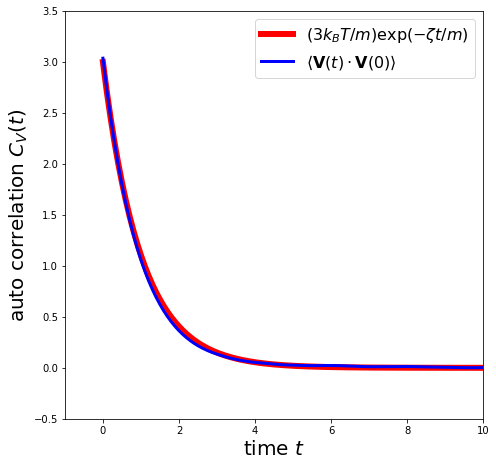

In [5]:
fig1, ax1 = plt.subplots(figsize=(7.5,7.5))
ax1.plot(time,dim*kBT/m*np.exp(-zeta/m*time),'r',lw=6, label=r'$(3k_BT/m)\exp(-\zeta t/m)$')
ax1.plot(time,corr,'b',lw=3,label=r'$\langle\mathbf{V}(t)\cdot \mathbf{V}(0)\rangle$')
ax1.set_xlabel(r"time $t$", fontsize=20)
ax1.set_ylabel(r"auto correlation $C_V(t)$", fontsize=20)
ax1.set_xlim(-1,10)
ax1.set_ylim(-0.5,3.5)
ax1.legend(fontsize=16)

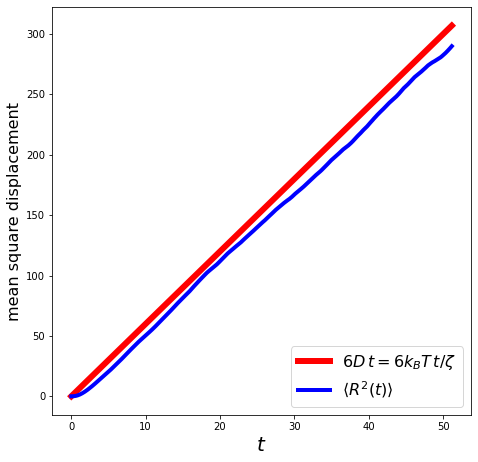

In [6]:
fig2, ax2 = plt.subplots(figsize=(7.5,7.5))
ax2.set_xlabel(r"$t$", fontsize=20)
ax2.set_ylabel(r"mean square displacement", fontsize=16)
ax2.plot(time,6*kBT/zeta*time,'r',lw=6, label=r'$6D\,t={6k_BT \,t}/{\zeta}$')
ax2.plot(time,msd,'b',lw=4, label=r'$\langle R^2(t)\rangle$')
ax2.legend(fontsize=16,loc=4)


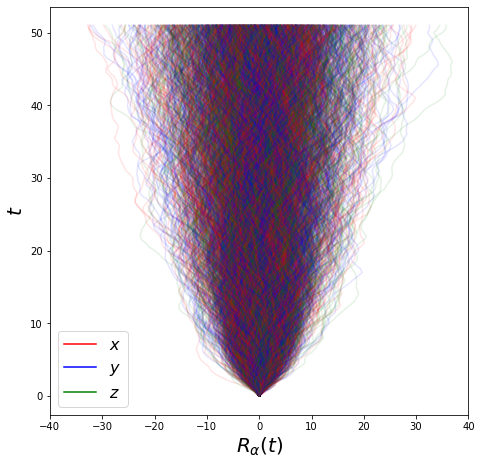

In [7]:
# particle positions vs time
fig3, ax3 = plt.subplots(figsize=(7.5,7.5))
ax3.set_xlabel(r"$R_{\alpha}(t)$", fontsize=20)
ax3.set_ylabel(r"$t$", fontsize=20)
ax3.set_xlim(-40,40)
ts = 10 # only draw every 10 points to make it faster
for n in range(nump):
    lx, = ax3.plot(Rs[::ts,n,0],time[::ts],'r', alpha=0.1)
    ly, = ax3.plot(Rs[::ts,n,1],time[::ts],'b', alpha=0.1)
    lz, = ax3.plot(Rs[::ts,n,2],time[::ts],'g', alpha=0.1)
# add plot legend for last x,y,z lines and remove alpha from legend lines
leg = ax3.legend([lx,ly,lz], [r"$x$",r"$y$",r"$z$"],loc=0, fontsize=16)
for l in leg.get_lines():
    l.set_alpha(1)

(-40.0, 40.0)

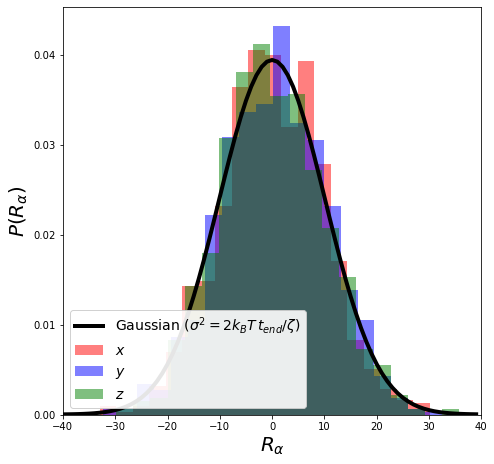

In [8]:
# positional distribution of particles at the end of the simulation
fig4, ax4 = plt.subplots(figsize=(7.5,7.5))
ax4.set_xlabel(r"$R_{\alpha}}(t=t_\mathrm{end})$", fontsize=20)
ax4.set_ylabel(r"$P(R_{\alpha})$", fontsize=20)
# plot simulation histograms
ax4.hist(Rs[-1,:,0], bins=20,density=True,color='r',alpha=0.5,lw=0,label=r"$x$")
ax4.hist(Rs[-1,:,1], bins=20,density=True,color='b',alpha=0.5,lw=0,label=r"$y$")
ax4.hist(Rs[-1,:,2], bins=20,density=True,color='g',alpha=0.5,lw=0,label=r"$z$")
# plot theoretical gaussian distribution
sig2=2*kBT/zeta*dt*nums
ave=0.0
x = np.arange(-40,40,1)
y = np.exp(-(x-ave)**2/2/sig2)/np.sqrt(2*np.pi*sig2)
ax4.plot(x,y,lw=4,color='k',label=r"Gaussian $(\sigma^2=2k_BT\,t_{end}/\zeta)$")
ax4.legend(fontsize=14,loc=3, framealpha=0.9)
ax4.set_xlim(-40,40)


(-6.0, 6.0)

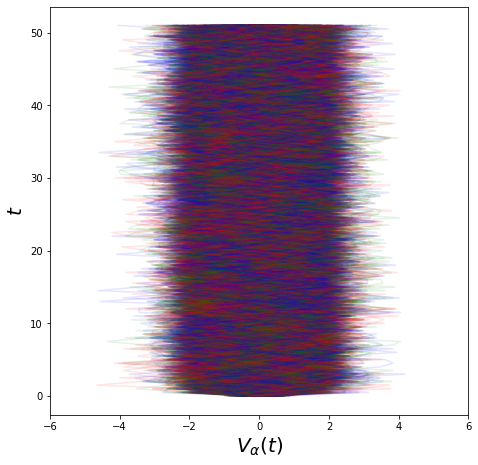

In [9]:
# particle velocities vs time
fig5, ax5 = plt.subplots(figsize=(7.5,7.5))
ax5.set_xlabel(r"$V_{\alpha}(t)$", fontsize=20)
ax5.set_ylabel(r"$t$", fontsize=20)
ts = 10 # only draw every 10 points to make it faster
for n in range(nump):
    lx, = ax5.plot(Vs[::ts,n,0],time[::ts],'r', alpha=0.1)
    ly, = ax5.plot(Vs[::ts,n,1],time[::ts],'b', alpha=0.1)
    lz, = ax5.plot(Vs[::ts,n,2],time[::ts],'g', alpha=0.1)
ax5.set_xlim(-6, 6)

(array([6.52150167e-05, 4.34766778e-05, 2.17383389e-05, 6.52150167e-05,
        2.17383389e-04, 3.04336745e-04, 2.60860067e-04, 4.13028439e-04,
        4.34766778e-04, 6.08673489e-04, 9.78225251e-04, 7.17365184e-04,
        1.08691695e-03, 1.23908532e-03, 2.17383389e-03, 2.26078725e-03,
        3.28248918e-03, 3.95637768e-03, 6.13021157e-03, 7.23886686e-03,
        8.86924227e-03, 1.14343663e-02, 1.59776791e-02, 1.89775699e-02,
        2.17166006e-02, 3.01945527e-02, 3.61073809e-02, 4.16071807e-02,
        5.05416380e-02, 6.20846959e-02, 7.11495832e-02, 8.31056696e-02,
        9.71268982e-02, 1.10169902e-01, 1.29886575e-01, 1.44559954e-01,
        1.67276518e-01, 1.87840987e-01, 2.06753341e-01, 2.22948404e-01,
        2.48338784e-01, 2.64707753e-01, 2.86967812e-01, 3.12814697e-01,
        3.23988203e-01, 3.38509413e-01, 3.61008594e-01, 3.70769108e-01,
        3.77160180e-01, 3.89094528e-01, 3.92681354e-01, 3.96746423e-01,
        3.92137896e-01, 3.81246988e-01, 3.81899138e-01, 3.660301

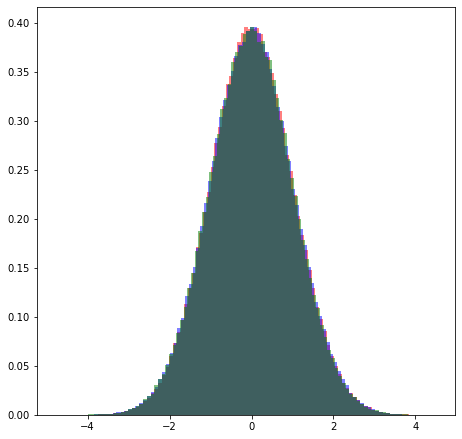

In [10]:
# add plot legend for last x,y,z lines and remove alpha from legend lines
leg = ax5.legend([lx,ly,lz], [r"$x$",r"$y$",r"$z$"],loc=0, fontsize=16)
for l in leg.get_lines():
    l.set_alpha(1)
# velocity distribution of particles at the end of the simulation
fig6, ax6 = plt.subplots(figsize=(7.5,7.5))
# Compute histogram of velocities using the last half of the trajectory data
# Note: flatten is required to transform the 2d array into a 1d array
ax6.hist(Vs[nums//2:,:,0].flatten(),bins=100,density=True,alpha=0.5,lw=0,color='r',label="x")
ax6.hist(Vs[nums//2:,:,1].flatten(),bins=100,density=True,alpha=0.5,lw=0,color='b',label="y")
ax6.hist(Vs[nums//2:,:,2].flatten(),bins=100,density=True,alpha=0.5,lw=0,color='g',label="z")

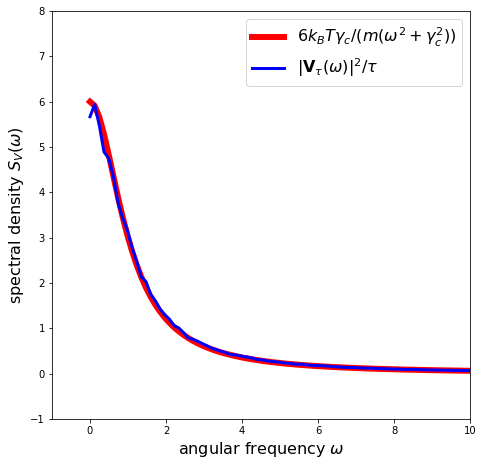

In [12]:
# Draw theoretical gaussian distribution
sig2=kBT/m
ave=0.0
x = np.arange(-10,10,0.1)
y = np.exp(-(x-ave)**2/2/sig2)/np.sqrt(2*np.pi*sig2)
ax6.plot(x,y,lw=4,color='k',label=r"Maxwell-Boltzmann $(\sigma^2=k_BT/m)$")
ax6.set_xlabel(r"$V_{\alpha}$",fontsize=20)
ax6.set_ylabel(r"$P(V_{\alpha})$", fontsize=20)
ax6.set_xlim(-6, 6)
ax6.set_ylim(0, 0.5)
ax6.legend(fontsize=14, loc=3,framealpha=0.9)
# return power spectrum for positive frequencies of even signal v
from numpy import fft
def psd(v,dt):  
    vw = fft.fft(v)*dt # V(w) with zero-frequency component at vw(0)
    return np.abs(vw[:nums//2])**2/(nums*dt) # S_V for w > 0 (Eq. (G9))
Sw   = np.zeros([nums//2])
for n in range(nump):
    for d in range(dim):
        Sw = Sw + psd(Vs[:,n,d],dt) # power spectrum of d-component of velocity for particle n
Sw = Sw/nump
fig7, ax7 = plt.subplots(figsize=(7.5,7.5))
gamma = zeta/m
omega = fft.fftfreq(nums,d=dt)[:nums//2]*2.0*np.pi
ax7.plot(omega,(6.0*kBT/m)*gamma/(omega**2 + gamma**2),'r',lw=6,label=r'$6k_BT\gamma_c/(m(\omega^2+\gamma_c^2))$')                         
ax7.plot(omega,Sw,'b',lw=3,label=r'$|\mathbf{V}_\tau(\omega)|^2 / \tau$')
ax7.set_xlabel(r"angular frequency $\omega$", fontsize=16)
ax7.set_ylabel(r"spectral density $S_V(\omega)$", fontsize=16)
ax7.legend(fontsize=16)
plt.xlim(-1, 10)
plt.ylim(-1, 8)



plt.show()